In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
dfs = pd.read_excel("lloyds_Customer_Churn_Data_Large.xlsx", sheet_name=None)

# Access individual sheets like this:
customer_demographic = dfs["Customer_Demographics"] 
transaction_history = dfs["Transaction_History"]
customer_service = dfs["Customer_Service"]
online_activity = dfs["Online_Activity"]
churn_status = dfs["Churn_Status"]

customer_demographic.head()

,CustomerID,Age,Gender,MaritalStatus,IncomeLevel
0,1,62,M,Single,Low
1,2,65,M,Married,Low
2,3,18,M,Single,Low
3,4,21,M,Widowed,Low
4,5,21,M,Divorced,Medium


In [3]:
df_dict = {
    "customer_demographic": customer_demographic,
    "transaction_history": transaction_history,
    "customer_service": customer_service,
    "online_activity": online_activity,
    "churn_status": churn_status
}

for name, df in df_dict.items():
    print(f"Info for {name}")
    print(df.info())

Info for customer_demographic
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     1000 non-null   int64 
 1   Age            1000 non-null   int64 
 2   Gender         1000 non-null   object
 3   MaritalStatus  1000 non-null   object
 4   IncomeLevel    1000 non-null   object
dtypes: int64(2), object(3)
memory usage: 39.2+ KB
None
Info for transaction_history
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5054 entries, 0 to 5053
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   CustomerID       5054 non-null   int64         
 1   TransactionID    5054 non-null   int64         
 2   TransactionDate  5054 non-null   datetime64[ns]
 3   AmountSpent      5054 non-null   float64       
 4   ProductCategory  5054 non-null   object        
dt

### Feature engineering for table's

In [4]:
tx = transaction_history.copy()
cs = customer_service.copy()
onl = online_activity.copy()

In [5]:
# Basic aggregates
tx_agg = (
    tx.groupby("CustomerID")
      .agg(
          transaction_count=("TransactionID", "nunique"),
          total_spent=("AmountSpent", "sum"),
          avg_spent=("AmountSpent", "mean"),
          median_spent=("AmountSpent", "median"),
          std_spent=("AmountSpent", "std"),
          max_spent=("AmountSpent", "max"),
          first_tx_date=("TransactionDate", "min"),
          last_tx_date=("TransactionDate", "max"),
          product_category_count=("ProductCategory", "nunique")
      )
      .reset_index()
)
tx_agg["std_spent"] = tx_agg["std_spent"].fillna(0.0)

# txn span and avg_days_between_txns (span / count)
tx_agg["txn_span_days"] = (tx_agg["last_tx_date"] - tx_agg["first_tx_date"]).dt.days
# avoid divide-by-zero: if transaction_count==0 keep NaN for now
tx_agg["avg_days_between_txns"] = tx_agg["txn_span_days"] / tx_agg["transaction_count"]
tx_agg["avg_days_between_txns"] = tx_agg["avg_days_between_txns"].fillna(0)

# active_months
tx["month_period"] = tx["TransactionDate"].dt.to_period("M")
active_months = tx.groupby("CustomerID")["month_period"].nunique().reset_index(name="active_months")
tx_agg = tx_agg.merge(active_months, on="CustomerID", how="left")
tx_agg["active_months"] = tx_agg["active_months"].fillna(0).astype(int)

# weekend ratio
tx["is_weekend"] = tx["TransactionDate"].dt.weekday >= 5
weekend_ratio = tx.groupby("CustomerID")["is_weekend"].mean().reset_index(name="txn_weekend_ratio")
tx_agg = tx_agg.merge(weekend_ratio, on="CustomerID", how="left")
tx_agg["txn_weekend_ratio"] = tx_agg["txn_weekend_ratio"].fillna(0)

# top product category and pct_spend_top_category
spend_by_cat = tx.groupby(["CustomerID", "ProductCategory"])["AmountSpent"].sum().reset_index()
top_idx = spend_by_cat.groupby("CustomerID")["AmountSpent"].idxmax()
top_cat = spend_by_cat.loc[top_idx, ["CustomerID", "ProductCategory", "AmountSpent"]].rename(
    columns={"ProductCategory": "top_product_category", "AmountSpent": "top_category_spend"}
).reset_index(drop=True)
tx_agg = tx_agg.merge(top_cat, on="CustomerID", how="left")
tx_agg["pct_spend_top_category"] = (tx_agg["top_category_spend"] / tx_agg["total_spent"]).fillna(0)

# Drop helper date columns we don't need as features
tx_feats = tx_agg.drop(columns=["first_tx_date", "last_tx_date", "top_category_spend", "txn_span_days"])

# -------------------------
# CUSTOMER_SERVICE -> interaction-level aggregates (no cutoff)
# Features:
# has_interaction, interaction_count, resolved_rate, dominant_interaction_type
# -------------------------
cs["InteractionDate"] = pd.to_datetime(cs["InteractionDate"])

# Keep rows with InteractionID as valid interactions
cs_valid = cs.dropna(subset=["InteractionID"])

# interaction counts & resolved rate
cs_counts = cs_valid.groupby("CustomerID").agg(
    interaction_count=("InteractionID", "nunique")
).reset_index()

# resolved rate
cs_valid["is_resolved"] = (cs_valid["ResolutionStatus"] == "Resolved").astype(int)
resolved_counts = cs_valid.groupby("CustomerID")["is_resolved"].sum().reset_index(name="resolved_count")
cs_feats = cs_counts.merge(resolved_counts, on="CustomerID", how="left")
cs_feats["resolved_count"] = cs_feats["resolved_count"].fillna(0)
cs_feats["resolved_rate"] = (cs_feats["resolved_count"] / cs_feats["interaction_count"]).fillna(0)

# dominant (most common) interaction type per customer
if "InteractionType" in cs_valid.columns:
    dominant_type = (
        cs_valid.groupby("CustomerID")["InteractionType"]
        .agg(lambda s: s.mode().iat[0] if not s.mode().empty else np.nan)
        .reset_index(name="interaction_type_mode")
    )
    cs_feats = cs_feats.merge(dominant_type, on="CustomerID", how="left")

# has_interaction flag
cs_feats["has_interaction"] = (cs_feats["interaction_count"] > 0).astype(int)

# Drop helper resolved_count
cs_feats = cs_feats.drop(columns=["resolved_count"], errors="ignore")

# -------------------------
# ONLINE_ACTIVITY -> online aggregates (no cutoff)
# Features:
# login_frequency_mean, login_frequency_max, serviceusage_mode, serviceusage_* indicator columns
# -------------------------
onl["LastLoginDate"] = pd.to_datetime(onl["LastLoginDate"])

# aggregate login frequency & service usage mode (keep original categorical form)
onl_agg = (
    onl.groupby("CustomerID")
       .agg(
           login_frequency_mean=("LoginFrequency", "mean"),
           login_frequency_max=("LoginFrequency", "max"),
           serviceusage_mode=("ServiceUsage", lambda s: s.mode().iat[0] if len(s) > 0 else np.nan),
           records_count=("CustomerID", "count")
       )
       .reset_index()
)

# No one-hot columns here — keep serviceusage_mode as-is
onl_feats = onl_agg.copy()

# -------------------------
# MERGE (anchor on transaction_history customer set)
# -------------------------
customers = (
    tx_feats
    .merge(cs_feats, on="CustomerID", how="left")
    .merge(onl_feats, on="CustomerID", how="left")
)

# Cross-table feature: interaction_per_txn
customers["interaction_count"] = customers.get("interaction_count", 0).fillna(0)
customers["transaction_count"] = customers.get("transaction_count", 0).fillna(0)
customers["interaction_per_txn"] = (
    customers["interaction_count"] / customers["transaction_count"].replace(0, np.nan)
).fillna(0)

# Fill numeric NaNs with 0
num_cols = customers.select_dtypes(include=[np.number]).columns.tolist()
customers[num_cols] = customers[num_cols].fillna(0)

print("customer-level features shape:", customers.shape)
customers.head()

customer-level features shape: (1000, 22)


,CustomerID,transaction_count,total_spent,avg_spent,median_spent,std_spent,max_spent,product_category_count,avg_days_between_txns,active_months,...,pct_spend_top_category,interaction_count,resolved_rate,interaction_type_mode,has_interaction,login_frequency_mean,login_frequency_max,serviceusage_mode,records_count,interaction_per_txn
0,1,1,416.50,416.50000,416.50,0.000000,416.50,1,0.000000,1,...,1.000000,1.0,1.0,Inquiry,1.0,34.0,34,Mobile App,1,1.000000
1,2,7,1547.42,221.06000,199.73,119.923748,397.37,4,44.857143,5,...,0.513144,1.0,1.0,Inquiry,1.0,5.0,5,Website,1,0.142857
2,3,6,1702.98,283.83000,293.79,133.480409,419.95,4,39.833333,6,...,0.483429,1.0,1.0,Inquiry,1.0,3.0,3,Website,1,0.166667
3,4,5,917.29,183.45800,125.64,131.578239,382.39,4,43.800000,3,...,0.416869,2.0,0.5,Inquiry,1.0,2.0,2,Website,1,0.400000
4,5,8,2001.49,250.18625,219.48,129.778209,475.69,3,37.875000,6,...,0.459188,0.0,0.0,NaN,0.0,41.0,41,Website,1,0.000000


In [6]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              1000 non-null   int64  
 1   transaction_count       1000 non-null   int64  
 2   total_spent             1000 non-null   float64
 3   avg_spent               1000 non-null   float64
 4   median_spent            1000 non-null   float64
 5   std_spent               1000 non-null   float64
 6   max_spent               1000 non-null   float64
 7   product_category_count  1000 non-null   int64  
 8   avg_days_between_txns   1000 non-null   float64
 9   active_months           1000 non-null   int32  
 10  txn_weekend_ratio       1000 non-null   float64
 11  top_product_category    1000 non-null   object 
 12  pct_spend_top_category  1000 non-null   float64
 13  interaction_count       1000 non-null   float64
 14  resolved_rate           1000 non-null   f

In [7]:
# Replace NaNs in InteractionType / interaction_type_mode with 'no interaction'
if "interaction_type_mode" in customers.columns:
    customers["interaction_type_mode"] = customers["interaction_type_mode"].fillna("no interaction")
elif "InteractionType" in customers.columns:
    customers["InteractionType"] = customers["InteractionType"].fillna("no interaction")
    
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              1000 non-null   int64  
 1   transaction_count       1000 non-null   int64  
 2   total_spent             1000 non-null   float64
 3   avg_spent               1000 non-null   float64
 4   median_spent            1000 non-null   float64
 5   std_spent               1000 non-null   float64
 6   max_spent               1000 non-null   float64
 7   product_category_count  1000 non-null   int64  
 8   avg_days_between_txns   1000 non-null   float64
 9   active_months           1000 non-null   int32  
 10  txn_weekend_ratio       1000 non-null   float64
 11  top_product_category    1000 non-null   object 
 12  pct_spend_top_category  1000 non-null   float64
 13  interaction_count       1000 non-null   float64
 14  resolved_rate           1000 non-null   f

In [8]:
customers.nunique()

CustomerID                1000
transaction_count            9
total_spent                997
avg_spent                  998
median_spent               998
std_spent                  884
max_spent                  975
product_category_count       5
avg_days_between_txns      571
active_months                9
txn_weekend_ratio           25
top_product_category         5
pct_spend_top_category     856
interaction_count            3
resolved_rate                3
interaction_type_mode        4
has_interaction              2
login_frequency_mean        49
login_frequency_max         49
serviceusage_mode            3
records_count                1
interaction_per_txn         15
dtype: int64

We are going to combine customer_demographic, customer_service, online_activity, and churn_status on CustomerID where its arround 1000 values. Then we will evaluate transaction_history separately, and use join to extract various information.

In [9]:
for col in customer_demographic.columns:
    if customer_demographic[col].dtype == object:
        print(f"unique values in {col} are {customer_demographic[col].unique()}")

unique values in Gender are ['M' 'F']
unique values in MaritalStatus are ['Single' 'Married' 'Widowed' 'Divorced']
unique values in IncomeLevel are ['Low' 'Medium' 'High']


<Axes: >

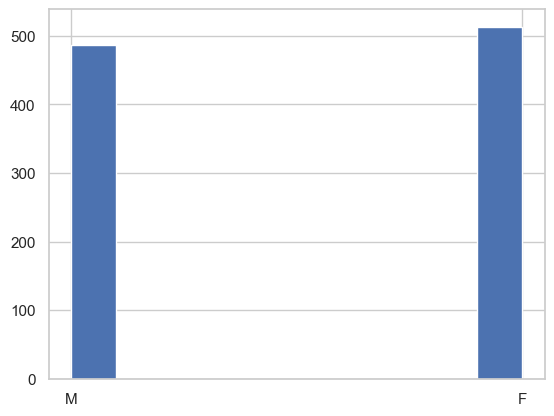

In [10]:
customer_demographic['Gender'].hist()

In [11]:
customer_demographic['Age'].unique()

array([62, 65, 18, 21, 57, 27, 37, 39, 68, 54, 41, 24, 42, 30, 19, 56, 64,
       35, 55, 43, 31, 26, 38, 69, 34, 23, 33, 36, 53, 67, 47, 32, 50, 49,
       28, 29, 46, 52, 58, 22, 59, 60, 45, 66, 48, 61, 20, 40, 44, 63, 51,
       25], dtype=int64)

<Axes: >

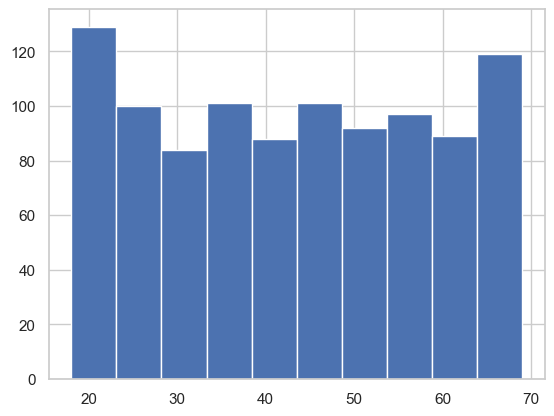

In [12]:
customer_demographic['Age'].hist()

{'whiskers': [<matplotlib.lines.Line2D at 0x1a4033058d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1a4033437d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a403306110>],
 'medians': [<matplotlib.lines.Line2D at 0x1a403354950>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a4010df250>],
 'means': []}

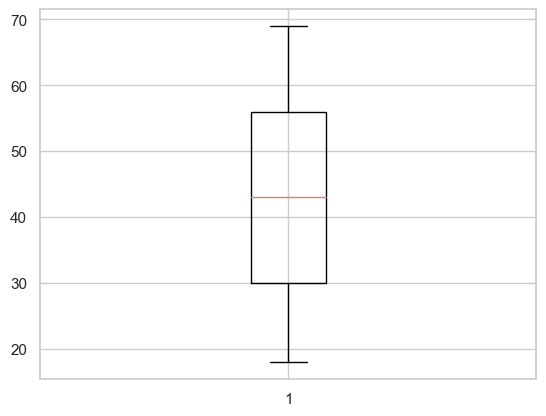

In [13]:
plt.boxplot(customer_demographic['Age'])

In [14]:
# Usual Age brackets 18 to 24 · 25 to 34 · 35 to 44 · 45 to 54 · 55 to 64 · 65 or over.
# Define the bins and corresponding labels
bins = [18, 25, 35, 45, 55, 65, 120]
labels = ['18 to 24', '25 to 34', '35 to 44', '45 to 54', '55 to 64', '65 or over']

# Create the new column using pd.cut
customer_demographic['Age_bracket'] = pd.cut(
    customer_demographic['Age'],
    bins=bins,
    labels=labels,
    right=False,  # Includes left edge, excludes right (e.g., 25 falls in '25-34', not '18-24')
    include_lowest=True  # Ensures the first bin includes 18
)

customer_demographic.head()

,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,Age_bracket
0,1,62,M,Single,Low,55 to 64
1,2,65,M,Married,Low,65 or over
2,3,18,M,Single,Low,18 to 24
3,4,21,M,Widowed,Low,18 to 24
4,5,21,M,Divorced,Medium,18 to 24


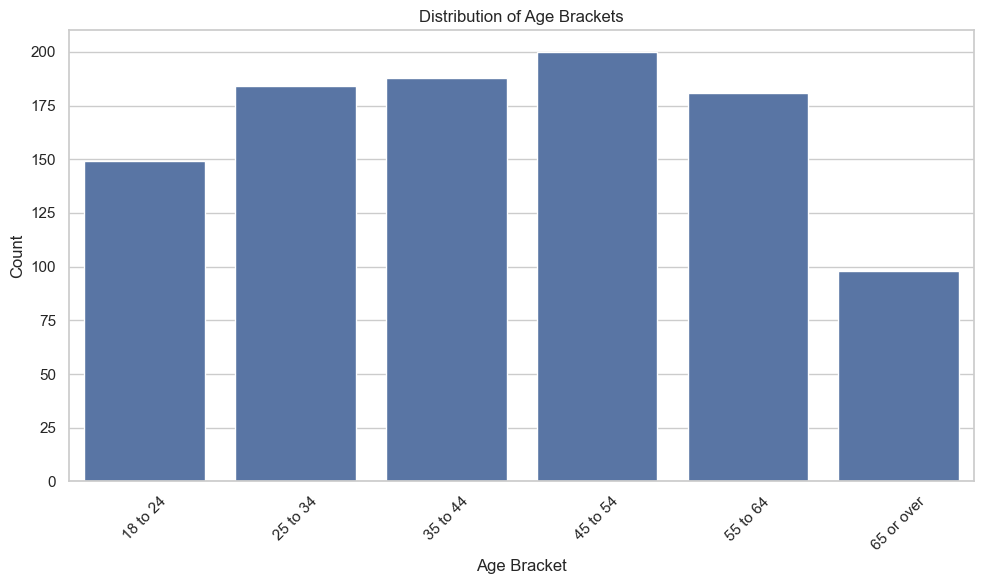

In [15]:
# Convert to ordered categorical
customer_demographic['Age_bracket'] = pd.Categorical(
    customer_demographic['Age_bracket'], 
    categories=labels, 
    ordered=True
)

# Plot with seaborn
plt.figure(figsize=(10, 6))
sns.countplot(x='Age_bracket', data=customer_demographic, order=labels)
plt.xlabel('Age Bracket')
plt.ylabel('Count')
plt.title('Distribution of Age Brackets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# Calculate the distribution
marital_income_dist = customer_demographic.groupby('MaritalStatus')['IncomeLevel'].value_counts().unstack(fill_value=0)

# Add a total column
marital_income_dist['Total'] = marital_income_dist.sum(axis=1)

print(marital_income_dist)

IncomeLevel    High  Low  Medium  Total
MaritalStatus                          
Divorced         82   87      79    248
Married          98   86      77    261
Single           75   62      78    215
Widowed          94   90      92    276


In [17]:
# Calculate percentages within each marital status group
marital_income_percent = customer_demographic.groupby('MaritalStatus')['IncomeLevel'].value_counts(normalize=True).unstack(fill_value=0) * 100

print(marital_income_percent)

IncomeLevel         High        Low     Medium
MaritalStatus                                 
Divorced       33.064516  35.080645  31.854839
Married        37.547893  32.950192  29.501916
Single         34.883721  28.837209  36.279070
Widowed        34.057971  32.608696  33.333333


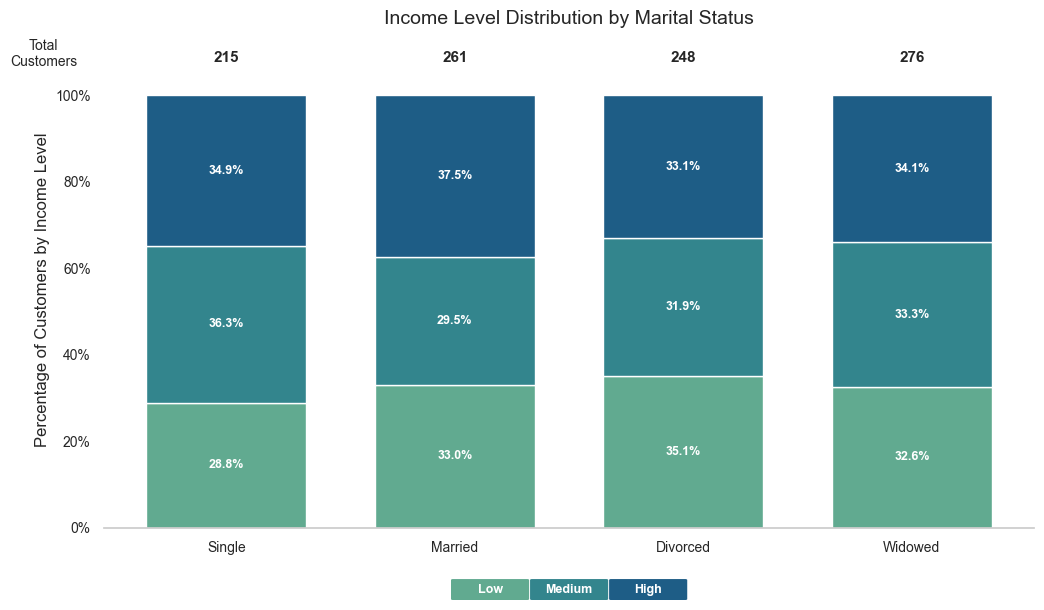

In [18]:
# Calculate the distribution of IncomeLevel within each MaritalStatus
marital_income_dist = customer_demographic.groupby('MaritalStatus')['IncomeLevel'].value_counts().unstack(fill_value=0)
marital_income_percent = customer_demographic.groupby('MaritalStatus')['IncomeLevel'].value_counts(normalize=True).unstack(fill_value=0) * 100

# Calculate total customers per marital status
marital_customers = customer_demographic.groupby('MaritalStatus').size().reset_index(name='num_customers')

# Order of marital status (you can customize this order if needed)
marital_order = ['Single', 'Married', 'Divorced', 'Widowed']

# Order of income levels
income_levels = ['Low', 'Medium', 'High']

# Colors (using a different palette than crest for variety)
palette = sns.color_palette("crest", 3)
colors = dict(zip(income_levels, palette))

plt.rcParams["font.family"] = "Arial"  # Use Arial font

fig, ax = plt.subplots(figsize=(12, 7))

# Reindex to ensure correct order
marital_income_percent = marital_income_percent.reindex(marital_order)
marital_income_dist = marital_income_dist.reindex(marital_order)

r = np.arange(len(marital_income_percent.index))
bar_width = 0.7
bottom = np.zeros(len(marital_income_percent.index))

# Stacked bars
for income_level in income_levels:
    values = marital_income_percent[income_level].fillna(0).values
    ax.bar(r, values, bottom=bottom, label=income_level, 
           color=colors[income_level], width=bar_width)
    
    # Add percentage labels
    for i, v in enumerate(values):
        if v > 5:  # Only show label for segments larger than 5%
            ax.text(r[i], bottom[i] + v/2, f"{v:.1f}%", 
                    ha='center', va='center', fontsize=9, color='white', weight='bold')
    bottom += values

# Add total customers at top of bars
for i, status in enumerate(marital_income_percent.index):
    total_customers = marital_customers[marital_customers['MaritalStatus'] == status]['num_customers'].values[0]
    ax.text(r[i], 107, str(total_customers), ha='center', va='bottom', 
            fontsize=11, weight='bold')

# Axis formatting
ax.set_xticks(r)
ax.set_xticklabels(marital_income_percent.index, rotation=0, ha='center', fontsize=10)
ax.set_ylabel("Percentage of Customers by Income Level", fontsize=12)
ax.set_ylim(0, 110)

# Format y-axis ticks as %
ax.set_yticks(np.arange(0, 110, 20))
ax.set_yticklabels([f"{y}%" for y in np.arange(0, 110, 20)], fontsize=10)

# Remove grid and extra spines
ax.grid(False)
for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)

# Add title
ax.set_title("Income Level Distribution by Marital Status", fontsize=14, pad=20)

# Add label for the total counts at the top
ax.text(-0.8, 106, "Total\nCustomers", ha='center', va='bottom',
        fontsize=10)

# Custom legend as boxes at bottom
box_w, box_h, spacing = 0.08, 0.04, 0.005
start_x = (1 - (3*box_w + 2*spacing)) / 2
legend_y = -0.15

for i, (lab, col) in enumerate(zip(income_levels, palette)):
    ax.add_patch(mpatches.FancyBboxPatch(
        (start_x + i*(box_w+spacing), legend_y),
        box_w, box_h,
        boxstyle="round,pad=0.002",
        facecolor=col, edgecolor="none", 
        transform=ax.transAxes,
        clip_on=False
    ))
    ax.text(start_x + i*(box_w+spacing) + box_w/2,
            legend_y + box_h/2,
            lab,
            va="center", ha="center",
            fontsize=9,
            color='white',
            weight='bold',
            transform=ax.transAxes,
            clip_on=False)

plt.subplots_adjust(bottom=0.2)
plt.show()

C:\Users\gpari\AppData\Local\Temp\ipykernel_15904\2066905564.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_income_dist = customer_demographic.groupby('Age_bracket')['IncomeLevel'].value_counts().unstack(fill_value=0)
C:\Users\gpari\AppData\Local\Temp\ipykernel_15904\2066905564.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_income_percent = customer_demographic.groupby('Age_bracket')['IncomeLevel'].value_counts(normalize=True).unstack(fill_value=0) * 100
C:\Users\gpari\AppData\Local\Temp\ipykernel_15904\2066905564.py:6: FutureWarning: The default of observed=False is deprecated and will be c

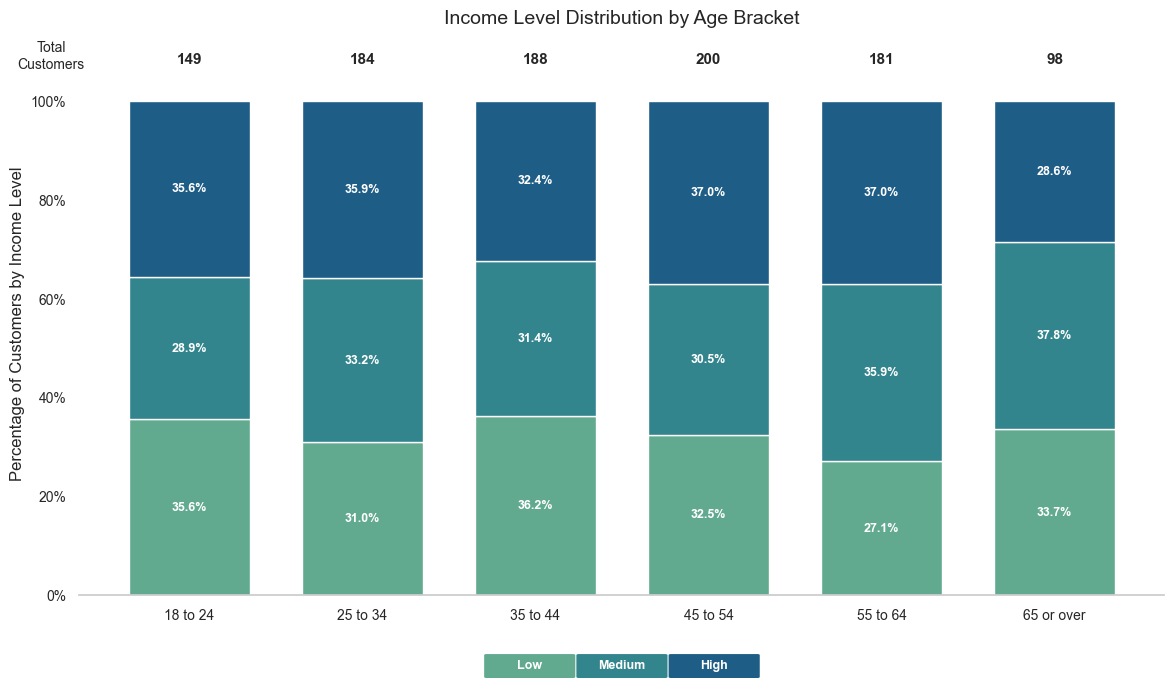

In [19]:
# Calculate the distribution of IncomeLevel within each Age_bracket
age_income_dist = customer_demographic.groupby('Age_bracket')['IncomeLevel'].value_counts().unstack(fill_value=0)
age_income_percent = customer_demographic.groupby('Age_bracket')['IncomeLevel'].value_counts(normalize=True).unstack(fill_value=0) * 100

# Calculate total customers per age bracket
age_customers = customer_demographic.groupby('Age_bracket').size().reset_index(name='num_customers')

# Order of age brackets from youngest to oldest
age_order = ['18 to 24', '25 to 34', '35 to 44', '45 to 54', '55 to 64', '65 or over']

# Order of income levels
income_levels = ['Low', 'Medium', 'High']

# Colors (using a different palette than crest for variety)
palette = sns.color_palette("crest", 3)
colors = dict(zip(income_levels, palette))

plt.rcParams["font.family"] = "Arial"  # Use Arial font

fig, ax = plt.subplots(figsize=(14, 8))

# Reindex to ensure correct order
age_income_percent = age_income_percent.reindex(age_order)
age_income_dist = age_income_dist.reindex(age_order)

r = np.arange(len(age_income_percent.index))
bar_width = 0.7
bottom = np.zeros(len(age_income_percent.index))

# Stacked bars
for income_level in income_levels:
    values = age_income_percent[income_level].fillna(0).values
    ax.bar(r, values, bottom=bottom, label=income_level, 
           color=colors[income_level], width=bar_width)
    
    # Add percentage labels
    for i, v in enumerate(values):
        if v > 5:  # Only show label for segments larger than 5%
            ax.text(r[i], bottom[i] + v/2, f"{v:.1f}%", 
                    ha='center', va='center', fontsize=9, color='white', weight='bold')
    bottom += values

# Add total customers at top of bars
for i, bracket in enumerate(age_income_percent.index):
    total_customers = age_customers[age_customers['Age_bracket'] == bracket]['num_customers'].values[0]
    ax.text(r[i], 107, str(total_customers), ha='center', va='bottom', 
            fontsize=11, weight='bold')

# Axis formatting
ax.set_xticks(r)
ax.set_xticklabels(age_income_percent.index, rotation=0, ha='center', fontsize=10)
ax.set_ylabel("Percentage of Customers by Income Level", fontsize=12)
ax.set_ylim(0, 110)

# Format y-axis ticks as %
ax.set_yticks(np.arange(0, 110, 20))
ax.set_yticklabels([f"{y}%" for y in np.arange(0, 110, 20)], fontsize=10)

# Remove grid and extra spines
ax.grid(False)
for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)

# Add title
ax.set_title("Income Level Distribution by Age Bracket", fontsize=14, pad=20)

# Add label for the total counts at the top
ax.text(-0.8, 106, "Total\nCustomers", ha='center', va='bottom',
        fontsize=10)

# Custom legend as boxes at bottom
box_w, box_h, spacing = 0.08, 0.04, 0.005
start_x = (1 - (3*box_w + 2*spacing)) / 2
legend_y = -0.15

for i, (lab, col) in enumerate(zip(income_levels, palette)):
    ax.add_patch(mpatches.FancyBboxPatch(
        (start_x + i*(box_w+spacing), legend_y),
        box_w, box_h,
        boxstyle="round,pad=0.002",
        facecolor=col, edgecolor="none", 
        transform=ax.transAxes,
        clip_on=False
    ))
    ax.text(start_x + i*(box_w+spacing) + box_w/2,
            legend_y + box_h/2,
            lab,
            va="center", ha="center",
            fontsize=9,
            color='white',
            weight='bold',
            transform=ax.transAxes,
            clip_on=False)

plt.subplots_adjust(bottom=0.2)
plt.show()

In [20]:
customer_demographic = customer_demographic.drop(columns='Age')

# Add custom table of features
merged_df = customer_demographic.merge(customers, on="CustomerID", how="outer")

# Add churn_status
merged_df = merged_df.merge(churn_status, on="CustomerID", how="outer")

print("Final merged dataframe shape:", merged_df.shape)
merged_df.head()

Final merged dataframe shape: (1000, 27)


,CustomerID,Gender,MaritalStatus,IncomeLevel,Age_bracket,transaction_count,total_spent,avg_spent,median_spent,std_spent,...,interaction_count,resolved_rate,interaction_type_mode,has_interaction,login_frequency_mean,login_frequency_max,serviceusage_mode,records_count,interaction_per_txn,ChurnStatus
0,1,M,Single,Low,55 to 64,1,416.50,416.50000,416.50,0.000000,...,1.0,1.0,Inquiry,1.0,34.0,34,Mobile App,1,1.000000,0
1,2,M,Married,Low,65 or over,7,1547.42,221.06000,199.73,119.923748,...,1.0,1.0,Inquiry,1.0,5.0,5,Website,1,0.142857,1
2,3,M,Single,Low,18 to 24,6,1702.98,283.83000,293.79,133.480409,...,1.0,1.0,Inquiry,1.0,3.0,3,Website,1,0.166667,0
3,4,M,Widowed,Low,18 to 24,5,917.29,183.45800,125.64,131.578239,...,2.0,0.5,Inquiry,1.0,2.0,2,Website,1,0.400000,0
4,5,M,Divorced,Medium,18 to 24,8,2001.49,250.18625,219.48,129.778209,...,0.0,0.0,no interaction,0.0,41.0,41,Website,1,0.000000,0


In [21]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   CustomerID              1000 non-null   int64   
 1   Gender                  1000 non-null   object  
 2   MaritalStatus           1000 non-null   object  
 3   IncomeLevel             1000 non-null   object  
 4   Age_bracket             1000 non-null   category
 5   transaction_count       1000 non-null   int64   
 6   total_spent             1000 non-null   float64 
 7   avg_spent               1000 non-null   float64 
 8   median_spent            1000 non-null   float64 
 9   std_spent               1000 non-null   float64 
 10  max_spent               1000 non-null   float64 
 11  product_category_count  1000 non-null   int64   
 12  avg_days_between_txns   1000 non-null   float64 
 13  active_months           1000 non-null   int32   
 14  txn_weekend_ratio       1

In [33]:
merged_df.nunique()

Gender                      2
MaritalStatus               4
IncomeLevel                 3
Age_bracket                 6
transaction_count           9
total_spent               997
avg_spent                 998
median_spent              998
std_spent                 884
max_spent                 975
product_category_count      5
avg_days_between_txns     571
active_months               9
txn_weekend_ratio          25
top_product_category        5
pct_spend_top_category    856
interaction_count           3
resolved_rate               3
interaction_type_mode       4
has_interaction             2
login_frequency_mean       49
login_frequency_max        49
serviceusage_mode           3
interaction_per_txn        15
ChurnStatus                 2
dtype: int64

In [23]:
merged_df = merged_df.drop(columns = ['CustomerID', 'records_count'])
merged_df.head()

,Gender,MaritalStatus,IncomeLevel,Age_bracket,transaction_count,total_spent,avg_spent,median_spent,std_spent,max_spent,...,pct_spend_top_category,interaction_count,resolved_rate,interaction_type_mode,has_interaction,login_frequency_mean,login_frequency_max,serviceusage_mode,interaction_per_txn,ChurnStatus
0,M,Single,Low,55 to 64,1,416.50,416.50000,416.50,0.000000,416.50,...,1.000000,1.0,1.0,Inquiry,1.0,34.0,34,Mobile App,1.000000,0
1,M,Married,Low,65 or over,7,1547.42,221.06000,199.73,119.923748,397.37,...,0.513144,1.0,1.0,Inquiry,1.0,5.0,5,Website,0.142857,1
2,M,Single,Low,18 to 24,6,1702.98,283.83000,293.79,133.480409,419.95,...,0.483429,1.0,1.0,Inquiry,1.0,3.0,3,Website,0.166667,0
3,M,Widowed,Low,18 to 24,5,917.29,183.45800,125.64,131.578239,382.39,...,0.416869,2.0,0.5,Inquiry,1.0,2.0,2,Website,0.400000,0
4,M,Divorced,Medium,18 to 24,8,2001.49,250.18625,219.48,129.778209,475.69,...,0.459188,0.0,0.0,no interaction,0.0,41.0,41,Website,0.000000,0


In [24]:
merged_df['interaction_type_mode']

0             Inquiry
1             Inquiry
2             Inquiry
3             Inquiry
4      no interaction
            ...      
995    no interaction
996    no interaction
997    no interaction
998    no interaction
999    no interaction
Name: interaction_type_mode, Length: 1000, dtype: object

In [25]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Gender                  1000 non-null   object  
 1   MaritalStatus           1000 non-null   object  
 2   IncomeLevel             1000 non-null   object  
 3   Age_bracket             1000 non-null   category
 4   transaction_count       1000 non-null   int64   
 5   total_spent             1000 non-null   float64 
 6   avg_spent               1000 non-null   float64 
 7   median_spent            1000 non-null   float64 
 8   std_spent               1000 non-null   float64 
 9   max_spent               1000 non-null   float64 
 10  product_category_count  1000 non-null   int64   
 11  avg_days_between_txns   1000 non-null   float64 
 12  active_months           1000 non-null   int32   
 13  txn_weekend_ratio       1000 non-null   float64 
 14  top_product_category    1

In [47]:
merged_df.describe()

,transaction_count,total_spent,avg_spent,median_spent,std_spent,max_spent,product_category_count,avg_days_between_txns,active_months,txn_weekend_ratio,pct_spend_top_category,interaction_count,resolved_rate,has_interaction,login_frequency_mean,login_frequency_max,interaction_per_txn,ChurnStatus
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,5.054000,1267.074950,248.806511,249.181900,120.275814,390.17738,3.097000,40.858364,4.104000,0.270909,0.579199,1.002000,0.352500,0.668000,25.912000,25.912000,0.302982,0.204000
std,2.603433,738.590013,79.372766,95.787249,62.803098,107.38038,1.252661,26.159493,1.959853,0.249285,0.224649,0.816494,0.425058,0.471167,14.055953,14.055953,0.420456,0.403171
min,1.000000,9.800000,9.800000,9.800000,0.000000,9.80000,1.000000,0.000000,1.000000,0.000000,0.235127,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,3.000000,626.685000,203.734167,187.431250,89.631426,342.85500,2.000000,28.741071,2.750000,0.000000,0.405289,0.000000,0.000000,0.000000,13.750000,13.750000,0.000000,0.000000
50%,5.000000,1232.880000,250.121458,246.845000,132.183417,429.92500,3.000000,38.750000,4.000000,0.250000,0.517431,1.000000,0.000000,1.000000,27.000000,27.000000,0.200000,0.000000
75%,7.000000,1791.902500,295.023854,313.356250,159.625759,468.50250,4.000000,50.875000,6.000000,0.400000,0.690307,2.000000,1.000000,1.000000,38.000000,38.000000,0.333333,0.000000
max,9.000000,3386.040000,496.990000,496.990000,334.305944,499.86000,5.000000,162.500000,9.000000,1.000000,1.000000,2.000000,1.000000,1.000000,49.000000,49.000000,2.000000,1.000000


<Axes: >

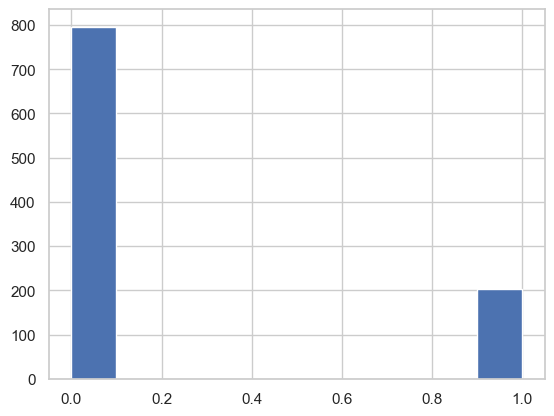

In [26]:
merged_df['ChurnStatus'].hist()

In [55]:
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix

RANDOM_STATE = 42
N_SPLITS = 5
EARLY_STOPPING_ROUNDS = 100
VERBOSE = 100

def objective(trial):
    # Suggest hyperparameters for CatBoost
    params = {
        'iterations': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'bootstrap_type': 'Bayesian',
        'eval_metric': 'AUC',
        'random_seed': RANDOM_STATE,
        'early_stopping_rounds': EARLY_STOPPING_ROUNDS,
        'verbose': 0,
        'auto_class_weights': 'Balanced'
    }
    
    # Stratified K-Fold CV
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    aucs = []
    
    for train_idx, val_idx in skf.split(X_train_full, y_train_full):
        X_train, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
        y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]
        
        train_pool = Pool(X_train, y_train, cat_features=cat_features)
        val_pool = Pool(X_val, y_val, cat_features=cat_features)
        
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=val_pool, use_best_model=True)
        
        y_prob = model.predict_proba(X_val)[:, 1]
        aucs.append(roc_auc_score(y_val, y_prob))
    
    # Return mean AUC across folds (maximize)
    return np.mean(aucs)

# ---------- Run the Optuna study ----------
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # You can increase n_trials for better search

print("Best trial:")
trial = study.best_trial
print(trial.params)

[I 2025-10-01 17:06:39,447] A new study created in memory with name: no-name-0be245f5-ffc1-4f82-a39b-fafda527e105
[I 2025-10-01 17:06:50,578] Trial 0 finished with value: 0.5843092142668068 and parameters: {'learning_rate': 0.010012933275753458, 'depth': 4, 'l2_leaf_reg': 1.6630078156913402, 'bagging_temperature': 0.11540582493160334}. Best is trial 0 with value: 0.5843092142668068.
[I 2025-10-01 17:07:10,291] Trial 1 finished with value: 0.5943973542169978 and parameters: {'learning_rate': 0.012270374503473496, 'depth': 7, 'l2_leaf_reg': 4.224562056148326, 'bagging_temperature': 0.9568893450572458}. Best is trial 1 with value: 0.5943973542169978.
[I 2025-10-01 17:07:22,709] Trial 2 finished with value: 0.5422569557067972 and parameters: {'learning_rate': 0.03082449556501627, 'depth': 5, 'l2_leaf_reg': 8.86620365790034, 'bagging_temperature': 0.08839038942058752}. Best is trial 1 with value: 0.5943973542169978.
[I 2025-10-01 17:07:47,078] Trial 3 finished with value: 0.5881284975430983

Best trial:
{'learning_rate': 0.02086657180368511, 'depth': 7, 'l2_leaf_reg': 3.7682518393323656, 'bagging_temperature': 0.9526906190493154}


For 50 trials

Trial 13 finished with value: 0.6032279048947895 and parameters: {'learning_rate': 0.01508257389434193, 'depth': 7, 'l2_leaf_reg': 4.983930376718413, 'bagging_temperature': 0.9837800406615571}.

Trial 20 finished with value: 0.6059305200597261 and parameters: {'learning_rate': 0.019035431615230258, 'depth': 7, 'l2_leaf_reg': 1.016859544364232, 'bagging_temperature': 0.9155860009883479}.

Trial 46 finished with value: 0.6098492013671408 and parameters: {'learning_rate': 0.02086657180368511, 'depth': 7, 'l2_leaf_reg': 3.7682518393323656, 'bagging_temperature': 0.9526906190493154}.

In [59]:

# ---------- CONFIG ----------
RANDOM_STATE = 42
TEST_SIZE = 0.20
N_SPLITS = 5
VERBOSE = 100
EARLY_STOPPING_ROUNDS = 500

# ---------- Prepare Data ----------
df_cat = merged_df.copy()

# Categorical features
cat_features = [
    'Gender', 'MaritalStatus', 'IncomeLevel', 'Age_bracket',
    'top_product_category', 'interaction_type_mode', 'serviceusage_mode'
]
cat_features = [c for c in cat_features if c in df_cat.columns]

# Ensure categorical features are strings
for c in cat_features:
    df_cat[c] = df_cat[c].astype(str).fillna('NA')

# Drop identifiers
if 'CustomerID' in df_cat.columns:
    df_cat = df_cat.drop(columns=['CustomerID'])

# Prepare X and y
y = df_cat['ChurnStatus'].astype(int)
X = df_cat.drop(columns=['ChurnStatus'])

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric cols:", numeric_cols)
print("Cat features to pass to CatBoost:", cat_features)

# ---------- Step 1: Stratified Train/Test Split ----------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print(f"Train shape: {X_train_full.shape}, Test shape: {X_test.shape}")

# ---------- Step 2: Stratified K-Fold on training set ----------
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

roc_auc_scores = []
f1_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full), 1):
    print(f"\n----- Fold {fold} -----")
    
    X_train, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]
    
    # CatBoost classifier
    cat = CatBoostClassifier(
        iterations=2000,
        learning_rate=0.0208,
        depth=7,
        l2_leaf_reg=3.7682,
        bagging_temperature=0.9526,
        bootstrap_type='Bayesian',
        eval_metric='AUC',
        random_seed=RANDOM_STATE,
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose=VERBOSE,
        auto_class_weights='Balanced'
    )
    
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)
    
    cat.fit(train_pool, eval_set=val_pool, use_best_model=True)
    
    # Predictions
    y_prob = cat.predict_proba(X_val)[:, 1]
    y_pred = cat.predict(X_val).astype(int)
    
    # Metrics
    roc_auc = roc_auc_score(y_val, y_prob)
    f1 = f1_score(y_val, y_pred, pos_label=1)
    roc_auc_scores.append(roc_auc)
    f1_scores.append(f1)
    
    print(f"ROC AUC: {roc_auc:.4f}, F1: {f1:.4f}")
    print("\nClassification report:\n", classification_report(y_val, y_pred))
    print("\nConfusion matrix:\n", confusion_matrix(y_val, y_pred))

print("\n===== Average CV Metrics =====")
print(f"Mean ROC AUC: {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")
print(f"Mean F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

# ---------- Step 3: Fit final model on full training set ----------
final_cat = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.0208,
    depth=7,
    l2_leaf_reg=3.7682,
    bagging_temperature=0.9526,
    bootstrap_type='Bayesian',
    eval_metric='AUC',
    random_seed=RANDOM_STATE,
    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
    verbose=VERBOSE,
    auto_class_weights='Balanced'
)

train_pool_full = Pool(X_train_full, y_train_full, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

final_cat.fit(train_pool_full, eval_set=test_pool, use_best_model=True)

# ---------- Step 4: Evaluate on hold-out test set ----------
y_prob_test = final_cat.predict_proba(X_test)[:, 1]
y_pred_test = final_cat.predict(X_test).astype(int)

roc_auc_test = roc_auc_score(y_test, y_prob_test)
f1_test = f1_score(y_test, y_pred_test, pos_label=1)

print("\n===== Final Test Set Metrics =====")
print(f"ROC AUC: {roc_auc_test:.4f}, F1: {f1_test:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred_test))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_test))

Numeric cols: ['transaction_count', 'total_spent', 'avg_spent', 'median_spent', 'std_spent', 'max_spent', 'product_category_count', 'avg_days_between_txns', 'active_months', 'txn_weekend_ratio', 'pct_spend_top_category', 'interaction_count', 'resolved_rate', 'has_interaction', 'login_frequency_mean', 'login_frequency_max', 'interaction_per_txn']
Cat features to pass to CatBoost: ['Gender', 'MaritalStatus', 'IncomeLevel', 'Age_bracket', 'top_product_category', 'interaction_type_mode', 'serviceusage_mode']
Train shape: (800, 24), Test shape: (200, 24)

----- Fold 1 -----
0:	test: 0.4521484	best: 0.4521484 (0)	total: 32ms	remaining: 1m 3s
100:	test: 0.6721191	best: 0.7011719 (67)	total: 2.92s	remaining: 55s
200:	test: 0.6298828	best: 0.7011719 (67)	total: 5.54s	remaining: 49.6s
300:	test: 0.6120605	best: 0.7011719 (67)	total: 8.4s	remaining: 47.4s
400:	test: 0.6123047	best: 0.7011719 (67)	total: 11.5s	remaining: 46s
500:	test: 0.6213379	best: 0.7011719 (67)	total: 14.5s	remaining: 43.4s
S

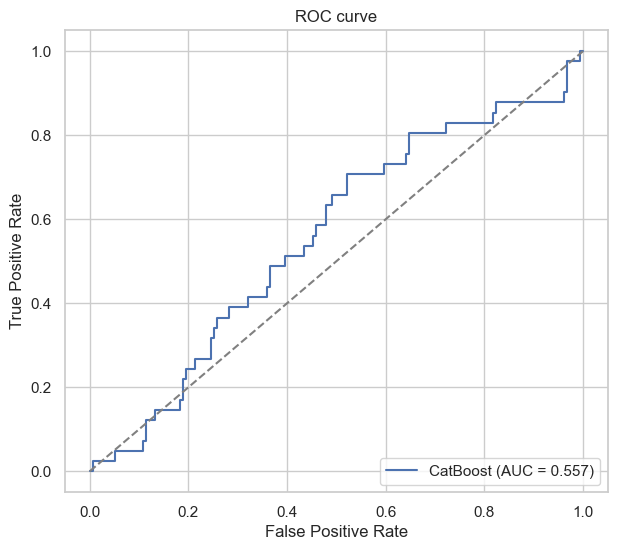

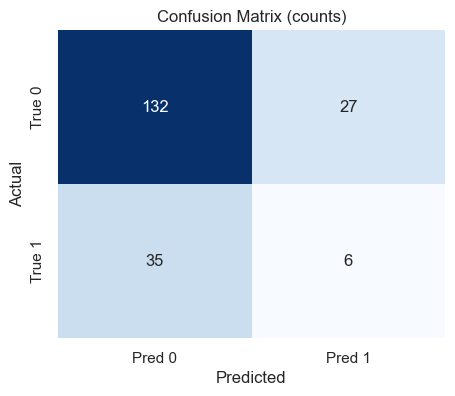

In [60]:
# Probabilities for ROC curve
y_prob_test = final_cat.predict_proba(X_test)[:, 1]
y_pred_test = final_cat.predict(X_test).astype(int)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'CatBoost (AUC = {roc_auc_test:.3f})')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Confusion matrix heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'])
plt.title('Confusion Matrix (counts)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

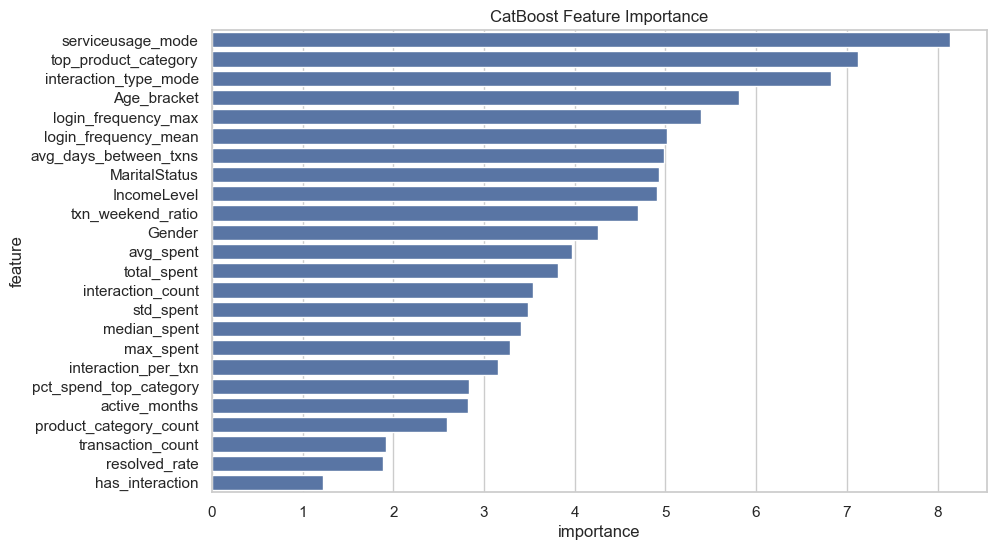

In [66]:
fi = final_cat.get_feature_importance(type='FeatureImportance')
feature_names = X_train_full.columns.tolist()
fi_df = pd.DataFrame({'feature': feature_names, 'importance': fi}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=fi_df)
plt.title('CatBoost Feature Importance')
plt.show()

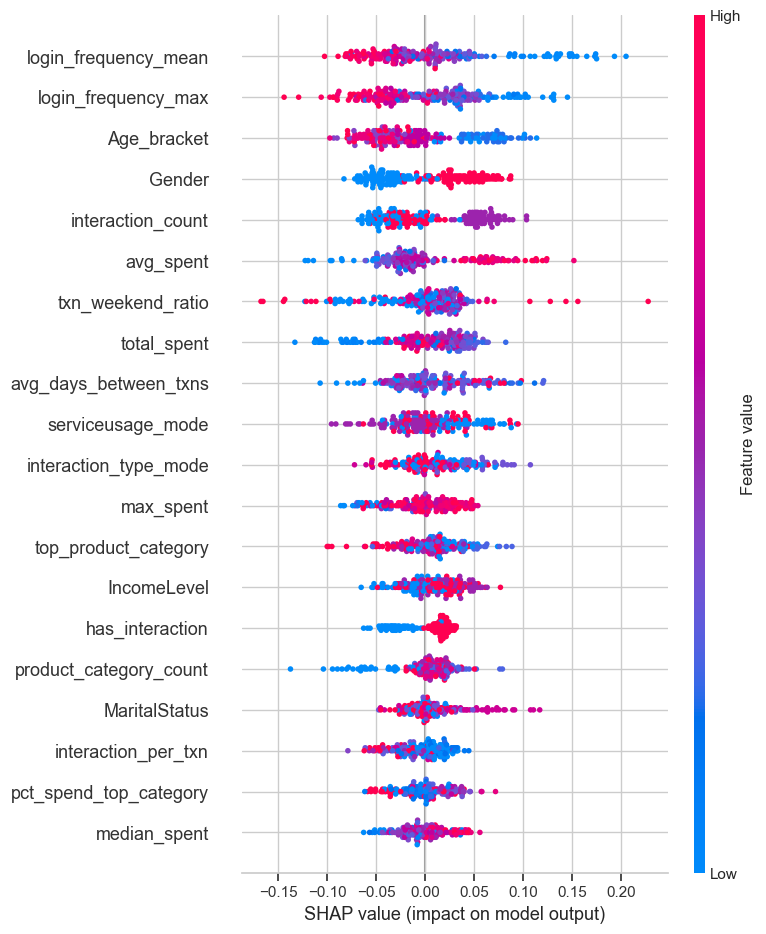

In [73]:
import shap

shap_values_full = final_cat.get_feature_importance(type='ShapValues', data=test_pool)
shap_vals = shap_values_full[:, :-1]

X_plot = X_test.copy()

# convert categorical columns to integer codes just for visualization
for c in cat_features:
    if c in X_plot.columns:
        X_plot[c] = pd.Categorical(X_plot[c]).codes
        
shap.summary_plot(shap_vals, X_plot, plot_type='dot')

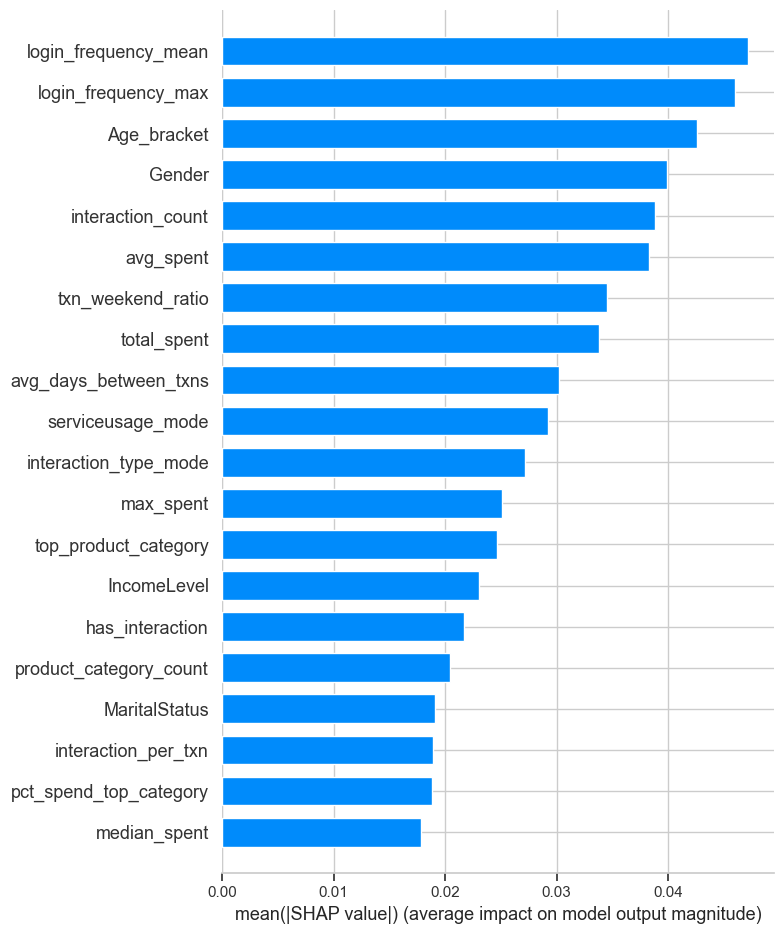

In [74]:
shap.summary_plot(shap_vals, X_test, plot_type='bar')

In [70]:
# y_prob_test is the predicted probabilities for the positive class
thresholds = np.arange(0.1, 0.9, 0.01)  # try thresholds from 0.1 to 0.9
best_threshold = 0.5
best_macro_f1 = 0

for t in thresholds:
    y_pred_t = (y_prob_test >= t).astype(int)
    macro_f1 = f1_score(y_test, y_pred_t, average='macro')
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_threshold = t

print(f"Best threshold for max macro F1: {best_threshold:.2f}")
print(f"Macro F1 at best threshold: {best_macro_f1:.4f}")

# Make predictions using this optimal threshold
y_pred_opt = (y_prob_test >= best_threshold).astype(int)

# Confusion matrix & classification report
cm = confusion_matrix(y_test, y_pred_opt)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred_opt))

Best threshold for max macro F1: 0.48
Macro F1 at best threshold: 0.5375

Confusion Matrix:
 [[119  40]
 [ 27  14]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.75      0.78       159
           1       0.26      0.34      0.29        41

    accuracy                           0.67       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.70      0.67      0.68       200



In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

df_num = merged_df.copy()

cat_features = [c for c in cat_features if c in df_num.columns]

# Ensure categorical columns are strings and fillna
for c in cat_features:
    df_num[c] = df_num[c].astype(str).fillna('NA')

# ====== Prepare X and y ======
assert 'ChurnStatus' in df_num.columns, "ChurnStatus must be present in merged_df"
y = df_num['ChurnStatus'].astype(int)
X = df_num.drop(columns=['ChurnStatus'])

# List numeric cols for scaling (exclude any encoded categoricals)
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric cols:", numeric_cols)
print("Categorical cols to encode:", cat_features)

# ====== Train / Test split (stratified) ======
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# ====== ColumnTransformer: scale numeric, one-hot encode categorical ======
# OneHotEncoder -> sparse=False to provide dense array (small cardinality in your case)
cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, numeric_cols),
        ("cat", cat_transformer, cat_features),
    ],
    remainder='drop',  # drop any other columns not listed
    sparse_threshold=0  # ensure dense numpy output
)

# Fit on train only, then transform train and test
preprocessor.fit(X_train)
X_train_tr = preprocessor.transform(X_train)
X_test_tr = preprocessor.transform(X_test)

# Note: if you want feature names later, you can extract them from the transformers (omitted here)

# ====== Helper for metrics printing ======
def evaluate_model(name, model, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test).astype(int)

    roc_auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    clf_report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n--- {name} ---")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"F1 score (pos class=1): {f1:.4f}")
    print("\nClassification report:\n", clf_report)
    print("\nConfusion matrix:\n", cm)

# ====== 1) XGBoost ======
# compute scale_pos_weight from the training set
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

xgb = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=6,
    objective='binary:logistic',
    use_label_encoder=False,      # suppress warning in recent xgboost versions
    eval_metric='auc',
    random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    # Move early_stopping_rounds and eval_metric here:
    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
)

# Fit with early stopping on validation set
xgb.fit(
    X_train_tr, y_train,
    eval_set=[(X_test_tr, y_test)],
    verbose=VERBOSE
)

# Evaluate
evaluate_model("XGBoost", xgb, X_test_tr, y_test)

Numeric cols: ['transaction_count', 'total_spent', 'avg_spent', 'median_spent', 'std_spent', 'max_spent', 'product_category_count', 'avg_days_between_txns', 'active_months', 'txn_weekend_ratio', 'pct_spend_top_category', 'interaction_count', 'resolved_rate', 'has_interaction', 'login_frequency_mean', 'login_frequency_max', 'interaction_per_txn']
Categorical cols to encode: ['Gender', 'MaritalStatus', 'IncomeLevel', 'Age_bracket', 'top_product_category', 'interaction_type_mode', 'serviceusage_mode']
[0]	validation_0-auc:0.47630
[100]	validation_0-auc:0.46173


C:\Users\gpari\AppData\Roaming\Python\Python311\site-packages\xgboost\callback.py:386: UserWarning: [16:10:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



--- XGBoost ---
ROC AUC: 0.4853
F1 score (pos class=1): 0.2364

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.65      0.71       159
           1       0.19      0.32      0.24        41

    accuracy                           0.58       200
   macro avg       0.49      0.48      0.47       200
weighted avg       0.66      0.58      0.61       200


Confusion matrix:
 [[103  56]
 [ 28  13]]


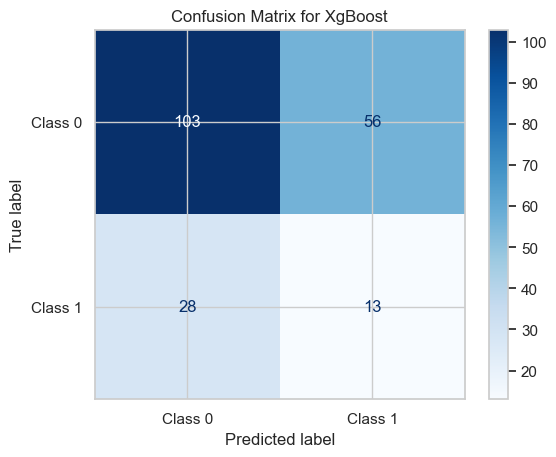

In [41]:
disp = ConfusionMatrixDisplay.from_estimator(
    xgb, X_test_tr, y_test, display_labels=['Class 0', 'Class 1'], cmap='Blues'
)
disp.ax_.set_title('Confusion Matrix for XgBoost')
plt.show()

In [42]:
# ====== 2) Balanced Random Forest (from imblearn) ======
brf = BalancedRandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

brf.fit(X_train_tr, y_train)

# Evaluate
evaluate_model("BalancedRandomForest", brf, X_test_tr, y_test)


--- BalancedRandomForest ---
ROC AUC: 0.5222
F1 score (pos class=1): 0.2069

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.77      0.78       159
           1       0.20      0.22      0.21        41

    accuracy                           0.66       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.67      0.66      0.66       200


Confusion matrix:
 [[122  37]
 [ 32   9]]


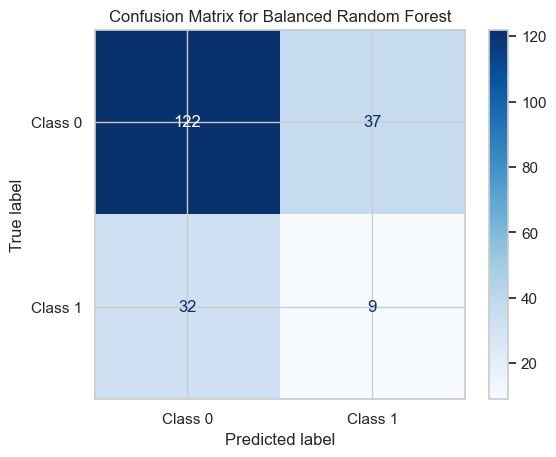

In [43]:
disp = ConfusionMatrixDisplay.from_estimator(
    brf, X_test_tr, y_test, display_labels=['Class 0', 'Class 1'], cmap='Blues'
)
disp.ax_.set_title('Confusion Matrix for Balanced Random Forest')
plt.show()

### Additional Info

1. Data Sets and Rationale
Four separate tables were provided, each containing different types of customer-related information:
Customer Demographics: CustomerID, Age, Gender, MaritalStatus, IncomeLevel
Rationale: Essential for understanding customer profiles and demographic factors affecting churn.
Transaction Data: CustomerID, TransactionID, TransactionDate, AmountSpent, ProductCategory
Rationale: Captures customer purchasing behavior, enabling analysis of spending patterns, product preferences, and engagement frequency.
Interaction Data: CustomerID, InteractionID, InteractionDate, InteractionType, ResolutionStatus
Rationale: Provides insights into customer support interactions, complaints resolution, and overall satisfaction.
Service Usage Data: CustomerID, LastLoginDate, LoginFrequency, ServiceUsage
Rationale: Reflects engagement with the service platform, helping identify inactive or highly active users.
By combining these tables, we aimed to build a holistic view of each customer, including demographics, spending behavior, support interactions, and service usage. This approach enables predictive modeling for churn prediction.

2. Data Cleaning and Preprocessing
The following steps were applied to transform raw data into a clean, feature-rich dataset:

2.1 Merging Tables
Action: Joined the four tables on CustomerID.
Reason: Consolidated all customer information into a single dataset for easier analysis and modeling.
Benefit: Simplifies feature engineering and avoids duplication when analyzing multiple dimensions (demographics, transactions, interactions, and usage).

2.2 Handling Categorical Variables
Gender, MaritalStatus, IncomeLevel: Kept as categorical features.
Age_bracket: Created based on Age (e.g., 18–25, 26–35) to reduce noise from individual ages.
Reason: Many modeling algorithms handle categories better, and age brackets capture group-level patterns.
Benefit: Reduces complexity while preserving meaningful demographic trends.

2.3 Transaction Feature Engineering
Derived multiple features from the transaction table:
transaction_count: Total number of transactions per customer
total_spent, avg_spent, median_spent, std_spent, max_spent: Capture spending habits
product_category_count: Number of unique product categories purchased
avg_days_between_txns, active_months: Measure transaction frequency
txn_weekend_ratio: Fraction of transactions occurring on weekends
top_product_category, pct_spend_top_category: Identify most important product for each customer
Reason: Raw transaction data is too granular for modeling; aggregated metrics provide actionable insights.
Benefit: Improves predictive power by summarizing customer engagement and spending behavior.

2.4 Interaction Feature Engineering
Derived from the interaction table:
interaction_count: Total support interactions
resolved_rate: Fraction of interactions resolved successfully
interaction_type_mode: Most common interaction type
has_interaction: Binary flag indicating whether the customer ever interacted with support
interaction_per_txn: Ratio of interactions to transactions
Reason: Customer support behavior often correlates with churn.
Benefit: Helps identify dissatisfied customers and patterns in support engagement.

2.5 Service Usage Feature Engineering
Derived from the service usage table:
login_frequency_mean, login_frequency_max: Average and peak login frequency
serviceusage_mode: Most frequent type of service usage
Reason: Active engagement with the platform reduces churn risk.
Benefit: Provides metrics for digital engagement and helps detect inactive customers.

2.6 Handling Missing Values
Action: All columns had 100% non-null values after preprocessing.
Reason: Feature engineering aggregated data in a way that filled gaps.
Benefit: No imputation required, which avoids introducing bias.

3. Exploratory Data Analysis (EDA)
3.1 Statistical Summary
From merged_df.describe():
transaction_count: Average of 5 transactions per customer; range 1–9
total_spent: Wide variation (min $9.8 – max $3386), indicating diverse spending behavior
interaction_count: Most customers had 0–2 interactions
login_frequency_mean: Average login ~26 days/month

3.2 Visualizations (suggested for report)
Histogram of total_spent and avg_spent to check spending distribution
Bar plots of Gender, MaritalStatus, IncomeLevel to show demographic composition
Boxplot of total_spent by Age_bracket to highlight spending trends
Scatterplot of interaction_count vs. transaction_count to see if high engagement correlates with more spending
Heatmap of correlations to identify relationships between numeric features and churn
Reason: EDA identifies patterns, potential outliers, and feature relationships.
Benefit: Guides model feature selection and highlights which variables are likely predictive of churn.

4. Cleaned and Preprocessed Data
The final dataset (merged_df) includes 25 columns per customer, combining demographic, transaction, interaction, and service usage information. All columns are numeric or categorical and contain no missing values.
Benefits of this final table:
Ready for machine learning models (classification for churn)
Aggregated features summarize historical customer behavior
Categorical variables are suitable for encoding techniques
High-quality, clean data ensures robust and reproducible results

This report demonstrates the workflow from raw tables to a merged, feature-rich dataset. Each step was purposeful, ensuring the dataset is interpretable, predictive, and ready for modeling customer churn.